In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import boto3

from PIL import Image

In [2]:
BUCKET_NAME = "film-stills"

In [3]:
s3 = boto3.client("s3")

In [4]:
from time import sleep

In [5]:
with open("data/file-info.json") as f: 
    file_info = [{"mid":i,**f} for i,f in enumerate(json.load(f))]

n_movies = len(file_info)
n_movies

2147

In [ ]:
%%time
bucket_objects = []
for mid in range(n_movies):
    resp = s3.list_objects(Bucket=BUCKET_NAME,Prefix=f"stills/{mid:04d}")
    if "Contents" not in resp:
        print(f"No stills found for film:",file_info[mid]["title"])
        continue
    bucket_objects.append({
        "mid":mid,
        "stills": [r["Key"] for r in resp["Contents"]]
    })
total_stills = sum(len(o["stills"]) for o in bucket_objects)
print(f"Found {total_stills} film_stills from {n_movies} movies")

In [ ]:
with open("data/bucket-objects.json","w") as f:
    json.dump(bucket_objects,f)

## Use PIL to Crop & Resize Images

In [6]:
import io

In [7]:
with open("data/bucket-objects.json") as f:
    bucket_objects = json.load(f)

In [10]:
test_key = bucket_objects[0]["stills"][0]
test_obj = s3.get_object(Bucket=BUCKET_NAME,Key=test_key)
test_bytes = io.BytesIO(test_obj["Body"].read())

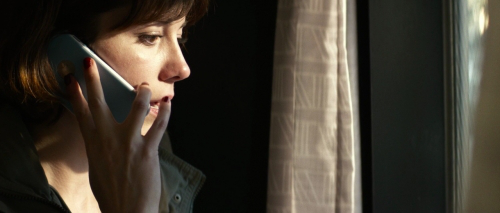

In [11]:
test_img = Image.open(test_bytes)
test_img

In [33]:
from IPython.display import ProgressBar
from pathlib import Path

In [48]:
def read_image(bucket,key):
    obj = s3.get_object(Bucket=bucket,Key=str(key))
    b = io.BytesIO(obj["Body"].read())
    return Image.open(b)

In [49]:
def resize_image(img,newwidth,aspect_ratio):
    oldwidth, oldheight = img.size
    newheight = int(newwidth / aspect_ratio)
    # find intermediate repr
    iheight = int(oldwidth / aspect_ratio)
    vpad = int((iheight - oldheight) / 2)
    # Crop then resize
    return img.crop(
        (0,-vpad,oldwidth,oldheight+vpad)
    ).resize(
        (newwidth,newheight)
    )

In [84]:
def image_to_file(img):
    b = io.BytesIO()
    img.save(b,"PNG")
    b.seek(0)
    return b

In [85]:
def upload_image(file,bucket,key):
    s3.upload_fileobj(Fileobj=file,Bucket=bucket,Key=str(key))

In [86]:
def parse_image(bucket,keya,keyb,new_width,new_ar):
    old_img = read_image(bucket,keya)
    new_img = resize_image(old_img,new_width,new_ar)
    file = image_to_file(new_img)
    upload_image(file,bucket,keyb)

In [92]:
movie_iterators = ({"mid":i,"len":len(m["stills"]),"stills":iter(m["stills"])} for i,m in enumerate(bucket_objects))

In [98]:
bar1 = ProgressBar(len(bucket_objects))
bar2 = ProgressBar(len(bucket_objects[0]["stills"]))
bar1.display()
bar2.display()

dest_bucket = Path("processed")
img_widths = 224
img_aspect_ratio = 16 / 9

starting_movie = -1
starting_still = -1

for i, movie in enumerate(bucket_objects):
    if i < starting_movie: 
        bar1.progress += 1
        continue
    
    bar2.total = len(movie["stills"])
    bar2.progress = 0
    for j, keya in enumerate(movie["stills"]):
        if i == starting_movie and j < starting_still:
            bar2.progress += 1
            continue
        
        keyb = (dest_bucket / Path(keya).name).with_suffix(".png")
        parse_image(
            BUCKET_NAME,
            keya,
            keyb,
            img_widths,
            img_aspect_ratio
        )
        bar2.progress += 1
    bar1.progress += 1

[============================================================] 2143/2143

[============================================================] 63/63

In [99]:
movie["mid"], keya

(2146, 'stills/2146_Zodiac_00062.jpg')